#pip install mglearn
#!pip install nltk

In [133]:
import pandas as pd
import numpy as np
import gzip
import markdown as md
import datetime

In [134]:
#Loading in the data
data = pd.read_csv('/data/dns/2022-08-13_dns.09:00:00-10:00:00.log', skiprows=8, delimiter='\t', header=None)

/data/dns/.virtualenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [135]:
#adding in column headers
data.rename(columns={0: 'ts', 1: 'uid', 2:'id_orig_h',3:'id_orig_p', 4:'id_resp_h', 5:'id_resp_p',
                    6:'proto', 7:'trans_id', 8:'rtt', 9:'query', 10:'qclass',
                    11:'qclass_', 12:'name', 13:'qtype', 14:'qtype_name', 15:'rcode', 16:'rcode_name',
                    17:'AA', 18:'TC', 19:'RD', 20:'RA', 21:'Z', 22:'answers', 23:'rejected' }, inplace= True)


In [136]:
#found one record that did not transfer well so it is dropped. 
data = data.drop(5903036, axis = 0)

#Selecting important columns
columns = ['id_orig_h', 'id_orig_p', 'id_resp_h', 
           'id_resp_p', 'trans_id', 'proto', 'query', 'qtype_name', 
           'answers']

data =  data[columns]

In [137]:
data.head(5)

,id_orig_h,id_orig_p,id_resp_h,id_resp_p,trans_id,proto,query,qtype_name,answers
0,3.239.154.191,14015.0,128.138.213.13,53.0,14481.0,udp,249.191.59.198.in-addr.arpa,-,-
1,1.38.3.21,41300.0,128.138.129.76,53.0,6060.0,udp,boulder.colorado.edu,-,-
2,2620:18f:20:2002::5,40914.0,2001:503:83eb::30,53.0,35327.0,udp,ns1.a2hosting.com,-,-
3,128.138.129.76,45621.0,13.107.222.240,53.0,1266.0,udp,ecs.office.trafficmanager.net,0,60.000000
4,218.241.242.237,16807.0,128.138.213.13,53.0,54435.0,udp,-,5,-


In [138]:
data.dtypes

id_orig_h      object
id_orig_p     float64
id_resp_h      object
id_resp_p     float64
trans_id      float64
proto          object
query          object
qtype_name     object
answers        object
dtype: object

In [139]:
#how many rows of data?
print(f'There are {len(data)} rows of data.')

There are 5903036 rows of data.


### Exploring the data
Here I am running value counts and exploring the top values to see what I can learn initially


In [140]:
#looking at the top hosts and response
host_ip = data['id_orig_h'].value_counts()
resp_ip = data['id_resp_h'].value_counts()

print(f'There are {len(host_ip)} unique host ip addresses.')
print(host_ip.head())
print(f'There are {len(resp_ip)} unique response ip addresses')
print(resp_ip.head())   

There are 70548 unique host ip addresses.
2620:18f:20:2002::5    656732
2620:18f:20:2::5       503656
2620:18f:20:1032::5    454681
128.138.130.30         260300
128.138.240.1          168442
Name: id_orig_h, dtype: int64
There are 19905 unique response ip addresses
128.138.213.13      1884139
128.138.240.1        379066
128.138.129.76       342807
128.138.130.30       333933
2600:1408:1c::81     122947
Name: id_resp_h, dtype: int64


In [141]:
#how many more instances of 128.138.213.13 are there than the next highest address?
resp_ip[0] - resp_ip[1]
#guessing that 128.138.213.13 is the CU DNS server

1505073

In [142]:
#diving into port numbers. 
#looking at port numbers that are not on the DNS port 53
#looking for any anomalies 
resp_port = data.loc[data['id_resp_p'] != 53]
resp_port_values = resp_port['id_resp_p'].value_counts()
resp_port_values

137.0      1079
5353.0      266
48932.0     219
42594.0      61
52084.0      34
           ... 
36116.0       1
48860.0       1
51484.0       1
46988.0       1
50286.0       1
Name: id_resp_p, Length: 66, dtype: int64

In [143]:
#checking the values of the different protocols used
#everything here looks as expected.
data.proto.value_counts()

udp    5815094
tcp      87942
Name: proto, dtype: int64

In [144]:
#query counts
data['query'].value_counts().head(25)

-                               1768211
249.191.59.198.in-addr.arpa      585165
india.colorado.edu               104051
utcnist.colorado.edu              91131
boulder.colorado.edu              70431
oldduke.colorado.edu              69087
otis.colorado.edu                 68497
colorado.edu                      51314
64.3.147.192.in-addr.arpa         34118
44.140.138.128.in-addr.arpa       33804
utcnist2.colorado.edu             27898
www.colorado.edu                  21518
(empty)                           19602
172.141.138.128.in-addr.arpa      19082
mx.colorado.edu                   15913
phet.colorado.edu                 15888
87.253.70.192.in-addr.arpa        13604
_.com.akadns.net                  12733
netdrms02.nispdc.nso.edu          11754
pool.ntp.org                      10976
sdo7.nascom.nasa.gov              10752
10.204.60.198.in-addr.arpa        10465
jsoc.stanford.edu                 10113
46.95.104.199.in-addr.arpa         9312
86.253.70.192.in-addr.arpa         8983


In [145]:
# blank queries were almost 2/5ths of the data. 
dash = data.loc[(data['query'] == '-') | (data['query'] == '(empty)')]
dash

,id_orig_h,id_orig_p,id_resp_h,id_resp_p,trans_id,proto,query,qtype_name,answers
4,218.241.242.237,16807.0,128.138.213.13,53.0,54435.0,udp,-,5,-
16,3.228.173.204,45919.0,128.138.213.13,53.0,27870.0,udp,-,0,-
17,2620:18f:20:1032::5,49121.0,2001:502:f3ff::d,53.0,50744.0,udp,-,3,-
18,3.239.154.191,18080.0,128.138.213.13,53.0,35492.0,udp,-,0,-
27,2620:18f:20:2002::5,40607.0,2001:67c:e0::2,53.0,36270.0,udp,-,3,-
...,...,...,...,...,...,...,...,...,...
5903016,111.206.170.75,43955.0,128.138.213.13,53.0,33948.0,udp,-,0,-
5903019,2400:cb00:15:1024::6ca2:dc22,56674.0,2620:18f:20:2::5,53.0,43016.0,udp,-,0,-
5903020,202.101.173.148,59567.0,128.138.213.13,53.0,26472.0,udp,-,5,-
5903029,2620:18f:20:1032::5,34125.0,2610:a1:1009::8,53.0,41889.0,udp,-,3,-


In [146]:
data.shape

(5903036, 9)

### Unit Test

In [147]:
import unittest
from pyspark.sql import SparkSession
from sklearn.cluster import KMeans

class TestDNSAnalysis(unittest.TestCase):

    def test_analyze_dns_data(self):
        # Create a sample DNS netflow DataFrame for testing
        data = [("2022-04-01 12:00:00", "192.168.1.1", "8.8.8.8", "A", "example.com", 1),
                ("2022-04-01 12:00:01", "192.168.1.2", "8.8.8.8", "A", "example.com", 2),
                ("2022-04-01 12:00:02", "192.168.1.3", "10.10.10.10", "A", "different.com", 3),]
        df = pd.DataFrame(data, columns = ["timestamp", "src_ip", "dst_ip", "qtype", "qname", "count"])
        X = df.groupby(['src_ip', 'dst_ip']).size().unstack(fill_value=0)

        # Run the DNS analysis function and check the results
        kmeans = KMeans(n_clusters=2, random_state = 28)
        result = kmeans.fit(X)
        self.assertEqual(len(result.labels_), 3)
        self.assertEqual(result.labels_[0], 0)
        self.assertEqual(result.labels_[1], 0)
        self.assertEqual(result.labels_[2], 1)




if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)


.
----------------------------------------------------------------------
Ran 1 test in 0.029s

OK


## Data Cleaning

In [148]:
# Drop rows with null or empty values in query column
data.dropna(subset=['query'], inplace=True)
# Drop rows with '-' in query column
data.drop(data[(data['query'] == '-') | (data['query'] == '(empty)')].index, inplace=True)
#drop direct ip address calls
data = data[~data['query'].str.endswith('in-addr.arpa')]

In [149]:
df = data.copy()

In [151]:
import re
from collections import Counter
import nltk

nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import wordnet
#splitting words on '.' or '-'
df['clean_query'] = df['query'].str.replace('[.-_]', ' ', n=-1)
df['clean_query'] = df['clean_query'].str.replace('[-]', '', n=-1)

#remove TLD's
tld = ['com', 'edu', 'gov', 'net', 'org', 'biz', 'akadns', 'www', 'https']
for x in tld:
    df['clean_query'] = df['clean_query'].str.replace(x, '')
    
# Define a regular expression pattern to match single and double letters
pattern = r'\b[a-zA-Z]{1,2}\b'

# Apply the pattern to the 'clean_query' column and replace the matches with an empty string
df['clean_query'] = df['clean_query'].apply(lambda x: re.sub(pattern, '', x))
    
# Define a function to split a domain name into words
def split_domain_into_words(domain):
    words = re.findall(r'[a-zA-Z0-9]+', domain)
    return words

# Create a new column for the length of the domain name
df['domain_length'] = df['query'].apply(lambda x: len(x))

#store words in a new column
df['words_split'] = df ['query'].apply(lambda x: split_domain_into_words (x))

# Create a new column for the number of words in the domain name
df['num_words'] = df['query'].apply(lambda x: len(split_domain_into_words(x)))

# Create a new column for the number of hyphens in the domain name
df['num_hyphens'] = df['query'].apply(lambda x: x.count('-'))

# Create a new column for the number of periods in the domain name
df['num_periods'] = df['query'].apply(lambda x: x.count('.'))

# Create a new column for the number of numeric tokens in the domain name
df['num_numeric_tokens'] = df['query'].apply(lambda x: len(re.findall(r'\d+', x)))

# Define a function to calculate the ratio of rare words in a domain name
def calc_rare_words_ratio(domain):
    words = split_domain_into_words(domain)
    word_counts = Counter(words)
    num_rare_words = sum([1 for word, count in word_counts.items() if count == 1])
    num_words = len(words)
    rare_words_ratio = num_rare_words / num_words if num_words > 0 else 0
    return rare_words_ratio

# Create a new column for the ratio of rare words in the domain name
df['rare_words_ratio'] = df['clean_query'].apply(lambda x: calc_rare_words_ratio(x))

# Define a function to calculate the ratio of common words in a domain name
def calc_common_words_ratio(domain):
    words = split_domain_into_words(domain)
    word_counts = Counter(words)
    num_common_words = sum([count for word, count in word_counts.items() if count > 1])
    num_words = len(words)
    common_words_ratio = num_common_words / num_words if num_words > 0 else 0
    return common_words_ratio

# Create a new column for the ratio of common words in the domain name
df['common_words_ratio'] = df['clean_query'].apply(lambda x: calc_common_words_ratio(x))

# Define a function to calculate the ratio of misspelled words in a domain name
def calc_misspelled_ratio(domain):
    words = split_domain_into_words(domain)
    num_misspelled_words = sum([1 for word in words if not wordnet.synsets(word)])
    num_words = len(words)
    misspelled_ratio = num_misspelled_words / num_words if num_words > 0 else 0
    return misspelled_ratio

# Create a new column for the ratio of misspelled words in the domain name
df['misspelled_ratio'] = df['clean_query'].apply(lambda x: calc_misspelled_ratio(x))

#one hot encoding for domain extensions
df['.com'] = df['query'].apply(lambda y: 1 if '.com' in y else 0)
df['.edu'] = df['query'].apply(lambda y: 1 if '.edu' in y else 0)
df['.gov'] = df['query'].apply(lambda y: 1 if '.gov' in y else 0)
df['.net'] = df['query'].apply(lambda y: 1 if '.net' in y else 0)
df['.biz'] = df['query'].apply(lambda y: 1 if '.biz' in y else 0)
df['.org'] = df['query'].apply(lambda y: 1 if '.org' in y else 0)

#entropy score
from scipy.stats import entropy

# Define a function to calculate entropy of a string
def calc_entropy(string):
    # Convert the string to a list of characters
    chars = list(string)
    # Count the frequency of each character
    freq = {}
    for char in chars:
        freq[char] = freq.get(char, 0) + 1
    # Calculate the probability of each character
    prob = [f/len(chars) for f in freq.values()]
    # Calculate the entropy using the probability distribution
    return entropy(prob)

# Calculate the entropy score for each row of the clean_query column
df['entropy_score'] = df['clean_query'].apply(calc_entropy)


[nltk_data] Downloading package wordnet to /home/chgo2707/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/chgo2707/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [152]:
from sklearn.preprocessing import LabelEncoder
#splitting the data set to create a testable model. 
important_cols = ['id_orig_h', 'id_resp_h', 'clean_query', 'domain_length',
       'num_words', 'num_hyphens', 'num_periods',
       'num_numeric_tokens', 
       'misspelled_ratio',
       'entropy_score']

df = df[important_cols]

cols = ['id_orig_h', 'id_resp_h', 'clean_query']

#turn the data into labels for the K-means algorithm
label_object = {}
for colm in cols:
    labelencoder = preprocessing.LabelEncoder()
    labelencoder.fit(df[colm])
    df[colm] = labelencoder.fit_transform(df[colm])
    label_object[colm] = labelencoder

In [153]:
df.head()

,id_orig_h,id_resp_h,clean_query,domain_length,num_words,num_hyphens,num_periods,num_numeric_tokens,misspelled_ratio,entropy_score
1,41,861,45814,20,3,0,2,0,0.000000,2.180840
2,38312,5540,11545,17,3,0,2,2,0.000000,1.893788
3,5273,1387,55692,29,4,0,3,0,0.333333,2.431131
5,5416,17910,60061,22,2,0,1,1,1.000000,2.406160
6,27335,1182,92131,20,3,0,2,0,0.500000,2.394700


In [154]:
df.shape

(2680259, 10)

### K-means clustering

In [156]:
#taking a sample of the data to use for faster run times. 
#change n for faster run times
#n=1250000
#clean_data = df.sample(n=n, random_state=28)
clean_data = df.copy()

In [157]:
#old code that might be useful in the future. 
#X = sample_data.groupby(['id.orig_h', 'query']).size().unstack(fill_value=0).to_numpy()

In [158]:
# Train the k-means clustering model
sse = []

for k in range(2, 11):
    print(f'Starting n_clusters = {k}')
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clean_data)
    sse.append(kmeans.inertia_)

Starting n_clusters = 2
Starting n_clusters = 3
Starting n_clusters = 4
Starting n_clusters = 5
Starting n_clusters = 6
Starting n_clusters = 7
Starting n_clusters = 8
Starting n_clusters = 9
Starting n_clusters = 10


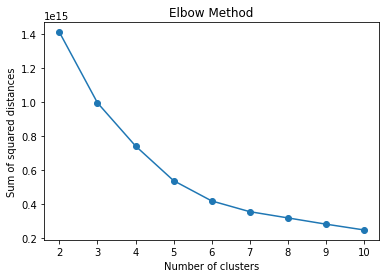

In [159]:
# plot sum of squared distances for each k
plt.plot(range(2, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method')
plt.show()

In [160]:
optimal_k = 6

In [161]:
#fitting kmeans with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(clean_data)
distances = kmeans.transform(clean_data)
anomaly_scores = distances.max(axis=1)
print(f'anomaly: {anomaly_scores}')
threshold = anomaly_scores.mean() + 2 * anomaly_scores.std()
print(f'threshold: {threshold}')
anomaly_indices = [i for i, score in enumerate(anomaly_scores) if score >= threshold]
print(f'indices: {anomaly_indices}')
anomalies = clean_data.iloc[anomaly_indices]
# Print the anomalous IP addresses
print(anomalies)

anomaly: [54740.63313535 77037.04198767 54806.42281509 ... 86455.6355503
 64972.5466518  46797.44274747]
threshold: 93596.0775457049
indices: [331, 480, 1540, 1760, 3552, 6773, 7176, 8250, 8492, 8526, 8588, 9946, 10860, 11174, 14874, 14978, 15631, 16323, 17264, 17559, 17760, 17816, 18382, 18441, 18834, 19779, 20273, 20434, 20445, 20702, 20852, 21469, 23826, 23833, 25421, 25749, 26141, 26397, 26457, 26686, 26792, 27085, 27473, 27703, 27704, 27848, 28207, 29077, 29597, 29780, 31103, 31555, 33345, 33869, 33934, 34168, 38212, 40837, 41128, 41665, 46212, 46854, 47500, 47561, 48564, 48721, 48747, 48969, 48983, 49003, 49005, 49033, 49093, 50953, 51123, 51233, 51271, 51344, 52091, 54424, 57213, 57924, 58103, 58194, 58256, 59401, 59651, 60940, 60975, 61010, 61184, 61191, 61423, 61478, 61525, 61897, 61924, 62903, 63246, 64078, 66065, 72212, 72330, 73273, 73326, 74164, 74193, 74632, 74803, 75148, 75176, 75199, 78097, 78381, 79393, 79480, 80734, 80945, 81941, 83840, 83917, 83960, 84722, 85329, 855

In [162]:
clean_data['anomaly'] = 0

for thing in clean_data.index:
    if thing in anomaly_indices:
        clean_data['anomaly'][thing] = 1

/data/dns/.virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [163]:
print(f'Number of anomalies:  {len(clean_data.loc[clean_data.anomaly == 1])}')

clean_data.loc[clean_data.anomaly == 1]

Number of anomalies:  2464


,id_orig_h,id_resp_h,clean_query,domain_length,num_words,num_hyphens,num_periods,num_numeric_tokens,misspelled_ratio,entropy_score,anomaly
1760,38309,14513,43758,12,2,0,1,0,0.000000,2.253858,1
7176,9923,861,49859,12,2,0,1,0,0.000000,1.831020,1
8250,38314,13136,43159,56,9,4,4,0,0.750000,2.669893,1
8492,5276,246,36595,36,5,1,3,2,0.666667,2.431278,1
8588,38312,12095,43258,25,3,0,2,1,0.500000,2.113719,1
...,...,...,...,...,...,...,...,...,...,...,...
2675541,50310,1135,89489,27,5,1,3,0,1.000000,2.547531,1
2675596,50310,1135,89520,18,4,1,2,0,0.500000,2.242973,1
2675924,5276,8449,11389,14,4,0,3,1,1.000000,1.073543,1
2677928,5276,2336,36626,18,3,0,2,0,0.000000,2.369382,1


### Building a Decision Tree to predict anomalies

In [164]:
from sklearn.model_selection import train_test_split
X = clean_data.iloc[:,:-1]
y = clean_data.iloc[:,-1]
# split data into training and test sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [165]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Decison Trees

In [179]:
from sklearn.tree import DecisionTreeClassifier

# Fit a decision tree classifier to the training data
clf = DecisionTreeClassifier(random_state=42, class_weight={0:1, 1:50})
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 1, 1: 50}, random_state=42)

In [180]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

y_pred = clf.predict(X_test)

# assume y_true and y_pred are the true labels and predicted labels, respectively
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", confusion)


Precision: 0.00179265013444876
Recall: 0.012170385395537525
Confusion Matrix:
 [[532218   3341]
 [   487      6]]


In [168]:
#pip install seaborn

<AxesSubplot:>

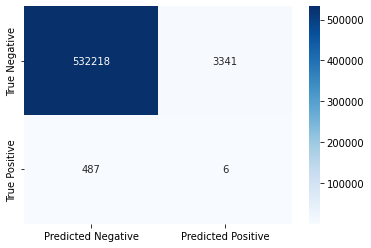

In [181]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# assuming you have already trained and made predictions on your test data using a decision tree classifier model
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# create a heatmap of the confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['True Negative', 'True Positive'])


In [170]:
#pip install keras
#pip install tensorflow

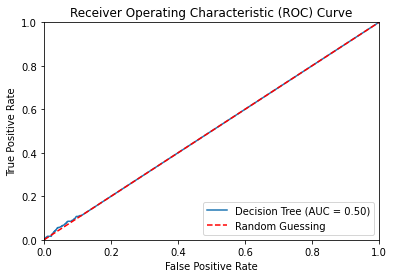

In [171]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# predict probabilities for test set using decision tree model
y_pred_prob = clf.predict_proba(X_test)[:,1]

# calculate fpr, tpr, and thresholds for different probability thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# calculate AUC score
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, label='Decision Tree (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--', label='Random Guessing')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


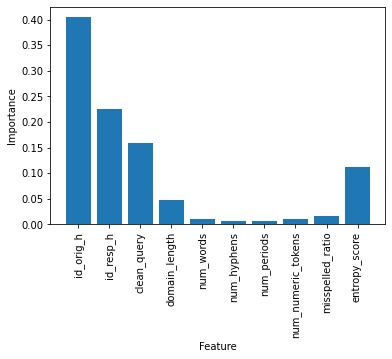

In [172]:
# get the feature importances
importances = clf.feature_importances_

# plot the feature importances
plt.bar(range(X_train.shape[1]), importances)
plt.xticks(range(X_train.shape[1]), clean_data.columns[:-1], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

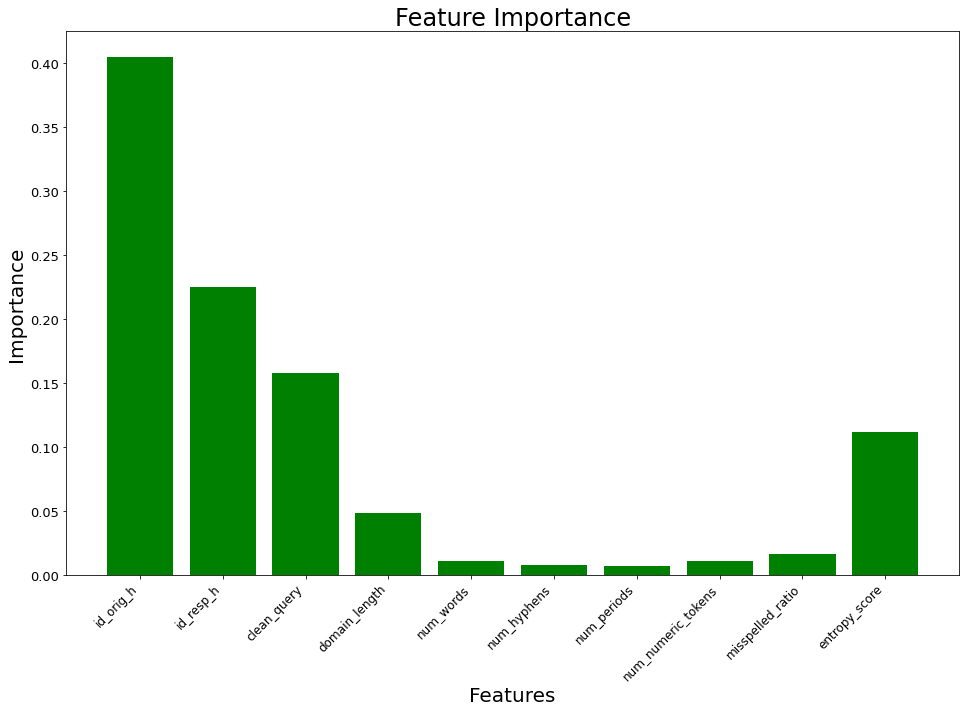

In [173]:
fig, ax = plt.subplots(figsize=(16, 10))

colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
ax.bar(range(X_train.shape[1]), importances, color='green')
ax.set_xticks(range(X_train.shape[1]))
ax.set_xticklabels(clean_data.columns[:-1], rotation=45, ha='right', fontsize=12)
ax.tick_params(axis='y', labelsize=13)
ax.set_xlabel("Features", fontsize=20)
ax.set_ylabel("Importance", fontsize=20)
ax.set_title('Feature Importance', fontsize = 24)
plt.show()


In [174]:
#changing back the label encoded values 
for thing in label_object:
    clean_data[thing] = label_object[thing].inverse_transform(clean_data[thing]) 

In [175]:
clean_data.head()

,id_orig_h,id_resp_h,clean_query,domain_length,num_words,num_hyphens,num_periods,num_numeric_tokens,misspelled_ratio,entropy_score,anomaly
1,1.38.3.21,128.138.129.76,boulder colorado,20,3,0,2,0,0.000000,2.180840,0
2,2620:18f:20:2002::5,2001:503:83eb::30,hosting,17,3,0,2,2,0.000000,1.893788,0
3,128.138.129.76,13.107.222.240,ecs office trafficmanager,29,4,0,3,0,0.333333,2.431131,0
5,128.138.240.1,94.138.217.18,globalconferences,22,2,0,1,1,1.000000,2.406160,0
6,204.14.22.8,128.138.240.1,utcnist colorado,20,3,0,2,0,0.500000,2.394700,0


In [176]:
#exploring the anomalies
anomalies = clean_data[clean_data['anomaly'] == 1]

In [177]:
anomalies.head(50)

,id_orig_h,id_resp_h,clean_query,domain_length,num_words,num_hyphens,num_periods,num_numeric_tokens,misspelled_ratio,entropy_score,anomaly
1760,2620:18f:20:1032::5,2a01:8840:45::33,august black,12,2,0,1,0,0.000000,2.253858,1
7176,161.97.193.124,128.138.129.76,colorado,12,2,0,1,0,0.000000,1.831020,1
8250,2620:18f:20:2::5,2620:1ec:bda::1,asfrisprodscusazsc southcentralus cloudapp azure,56,9,4,4,0,0.750000,2.669893,1
8492,128.138.130.30,104.47.40.8,proddns glbdns filtering,36,5,1,3,2,0.666667,2.431278,1
8588,2620:18f:20:2002::5,2606:4700:51::a29f:2005,assets cbsnewsstatic,25,3,0,2,1,0.500000,2.113719,1
17264,139.85.223.11,128.138.130.30,boulder colorado,20,3,0,2,0,0.000000,2.180840,1
17559,2620:18f:20:1032::5,2620:37:e000::53,arpa,18,6,0,6,3,1.000000,0.895333,1
17760,12.121.91.51,128.138.129.76,india colorado,18,3,0,2,0,0.000000,2.118649,1
17816,2620:18f:20:2002::5,2001:500:856e::30,maybusch,12,2,0,1,0,1.000000,2.197225,1
18382,2620:18f:20:2002::5,2600:1406:1b::41,edgekey,17,3,0,3,0,1.000000,1.594167,1


In [194]:
pip install scikit-learn

You should consider upgrading via the '/data/dns/.virtualenv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [192]:
!pip install imbalanced-learn

  Using cached imbalanced_learn-0.10.1-py3-none-any.whl (226 kB)
ERROR: Could not find a version that satisfies the requirement scikit-learn>=1.0.2 (from imbalanced-learn) (from versions: 0.9, 0.10, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.14, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.17, 0.17.1, 0.18, 0.18.1, 0.18.2, 0.19.0, 0.19.1, 0.19.2, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.20.4, 0.21.0, 0.21.1, 0.21.2, 0.21.3, 0.22, 0.22.1, 0.22.2, 0.22.2.post1, 0.23.0, 0.23.1, 0.23.2, 0.24.0, 0.24.1, 0.24.2)
ERROR: No matching distribution found for scikit-learn>=1.0.2 (from imbalanced-learn)
You should consider upgrading via the '/data/dns/.virtualenv/bin/python -m pip install --upgrade pip' command.


In [196]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the SVM classifier with the rbf kernel
svc = SVC(kernel='rbf', probability=True)

# Define the AdaBoost classifier with the SVM as the base estimator
boost = AdaBoostClassifier(base_estimator=svc, n_estimators=50, learning_rate=1)

# Train the model on the training data
boost.fit(X_train, y_train)

# Make predictions on the test data
y_pred = boost.predict(X_test)

# Generate the classification report
print(classification_report(y_test, y_pred))


KeyboardInterrupt: 

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# Predict on test set
y_proba = ada.predict_proba(X_test)[:, 1]

# Get confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get AUC score
auc = roc_auc_score(y_test, y_proba)

# Get feature importances
importances = ada.feature_importances_

# Plot feature importances
plt.bar(range(X_train.shape[1]), importances)
plt.xticks(range(X_train.shape[1]), clean_data.columns[:-1], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0,1], ['Predicted 0s', 'Predicted 1s'])
plt.yticks([0,1], ['True 0s', 'True 1s'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot AUC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
